In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import tqdm

In [2]:
## ONLY LOAD EVERY 10TH ROW JUST FOR DEBUGGING

# Load data
df = pd.read_csv("filtered_data.csv")#, skiprows=lambda i: i % 10 != 0)

print(df.shape)
df

(18322712, 6)


,station_id,year,month,element,day,value
0,AGM00060490,1957,1,TMAX,1,178
1,AGM00060490,1957,1,TMAX,2,150
2,AGM00060490,1957,1,TMAX,3,161
3,AGM00060490,1957,1,TMAX,4,172
4,AGM00060490,1957,1,TMAX,5,172
...,...,...,...,...,...,...
18322707,ZA000067753,1990,11,PRCP,26,0
18322708,ZA000067753,1990,11,PRCP,27,0
18322709,ZA000067753,1990,11,PRCP,28,0
18322710,ZA000067753,1990,11,PRCP,29,0


In [3]:
# For each station and for each day, compute the midpoint temperature by
# averaging the min and max temperatures
data_TEMP = df.where(np.logical_or(df["element"] == "TMIN", df["element"] == "TMAX"))
data_TEMP = data_TEMP.groupby(by=["station_id", "year", "month", "day"])
data_TEMP = data_TEMP.mean().reset_index()

data_TEMP["value"] /= 10
data_TEMP.rename(columns={"value": "TEMP"}, inplace=True)
data_TEMP[["year", "month", "day"]] = data_TEMP[["year", "month", "day"]].astype(int)
data_TEMP.set_index(keys=["station_id", "year", "month", "day"], inplace=True)

print(data_TEMP.shape)
data_TEMP.head()

(3754308, 1)


TEMP
station_id  year month day      
AGM00060490 1957 1     1    17.8
                       2    15.0
                       3    16.1
                       4     9.7
                       5     9.7

In [4]:
# Function that gets daily data for a specific metric, and joins it with the daily
# temperature data, so that we can compute correlation more easily
def get_temp_and_metric(metric):
    data_metric = df[df["element"] == metric]
    data_metric.drop(columns=["element"], inplace=True)
    data_metric.rename(columns={"value": metric}, inplace=True)
    data_metric.set_index(keys=["station_id", "year", "month", "day"], inplace=True)

    return data_TEMP.join(data_metric, how="inner")

In [5]:
# Function that, for each metric, computes correlation between temperature and *metric* for each (station, year) pair
def compute_correlations(metric_names):
    # Get data for each of the above metrics
    metric_name_to_df = {metric: get_temp_and_metric(metric) for metric in metric_names}
    print([x.shape for x in metric_name_to_df.values()])
    
    heatmaps = {}
    for metric in metric_names:
        metric_data = metric_name_to_df[metric]
        groupby = metric_data.groupby(by=["station_id", "year"])
        correlation_matrices = groupby.corr()
        correlations = correlation_matrices[metric].groupby(["station_id", "year"]).first()

        # Convert the pandas series into a 2D table, with station id as index and year as column
        correlation_heatmap = correlations.unstack(level=-1)

        print(f"TEMP vs. {metric}: {correlation_heatmap.shape}")

        # Get all distinct stations and distinct years so we can plot them on the graph
        stations = np.sort(metric_data.index.map(lambda pair: pair[0]).unique())
        years = np.sort(metric_data.index.map(lambda pair: pair[1]).unique())
        
        heatmaps[metric] = correlation_heatmap, stations, years

    return heatmaps

In [6]:
metric_names = ["PRCP", "SNOW", "WT01", "WT03", "WT08"]
heatmaps = compute_correlations(metric_names)

/tmp/ipykernel_12475/3260766738.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_metric.drop(columns=["element"], inplace=True)
/tmp/ipykernel_12475/3260766738.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_metric.rename(columns={"value": metric}, inplace=True)
/tmp/ipykernel_12475/3260766738.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_metric.drop(columns=["element"], inplace=True)
/tmp/ipykernel_12475/32

[(3433075, 2), (1530421, 2), (0, 2), (0, 2), (0, 2)]
TEMP vs. PRCP: (324, 145)
TEMP vs. SNOW: (181, 145)
TEMP vs. WT01: (0, 0)
TEMP vs. WT03: (0, 0)
TEMP vs. WT08: (0, 0)


In [7]:
# A pandas series mapping station ID's to names
station_names = pd.read_fwf("ghcnd-stations.txt", header=None, usecols=[0, 4])
station_names.rename(columns={0: "station_id", 4: "station_name"}, inplace=True)
station_names = station_names.set_index(keys="station_id").squeeze()

In [8]:
# Plot a heatmap of correlations between temperature and precipitation, for each station and each year
def plot_heatmap(metric, year_tick_frequency, station_tick_frequency):
    array, stations, years = heatmaps[metric]

    # Don't plot the stations that have no data at all (i.e. stations that have all NaN correlations)
    array = array[~array.isna().all(axis=1)]
    print(f"Heatmap has shape {array.shape}")

    plt.figure(figsize=(40, 10))
    plt.imshow(array, cmap="seismic")
    plt.colorbar()
    
    plt.xticks(ticks=np.arange(len(years))[::year_tick_frequency], labels=years[::year_tick_frequency])
    plt.yticks(ticks=np.arange(len(stations))[::station_tick_frequency], labels=station_names[stations[::station_tick_frequency]])
    #plt.xlim(0, len(years))
    #plt.ylim(0, len(stations))
    plt.grid()
    plt.show()

Heatmap has shape (319, 145)


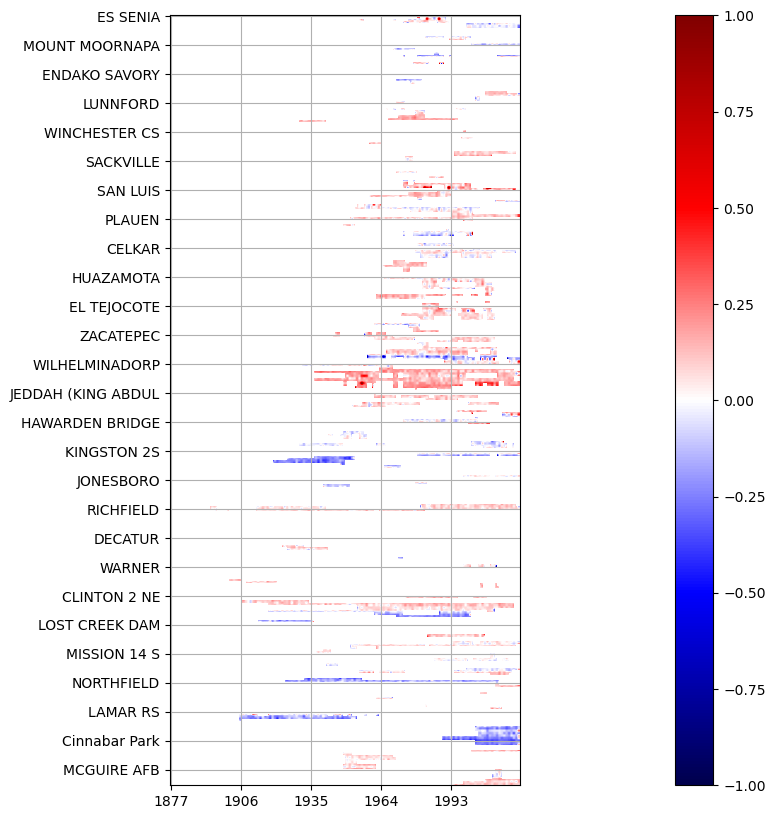

Heatmap has shape (161, 145)


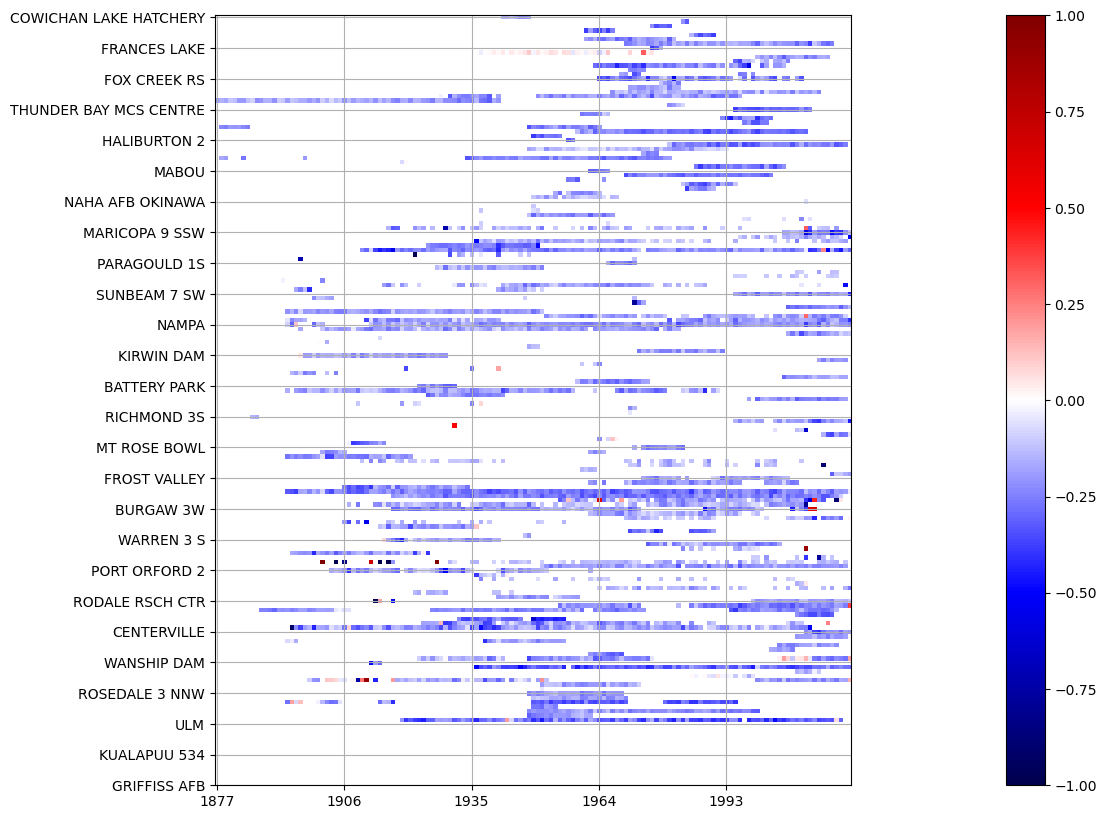

Heatmap has shape (0, 0)


/tmp/ipykernel_12475/3572449379.py:10: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(array, cmap="seismic")
/tmp/ipykernel_12475/3572449379.py:10: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(array, cmap="seismic")


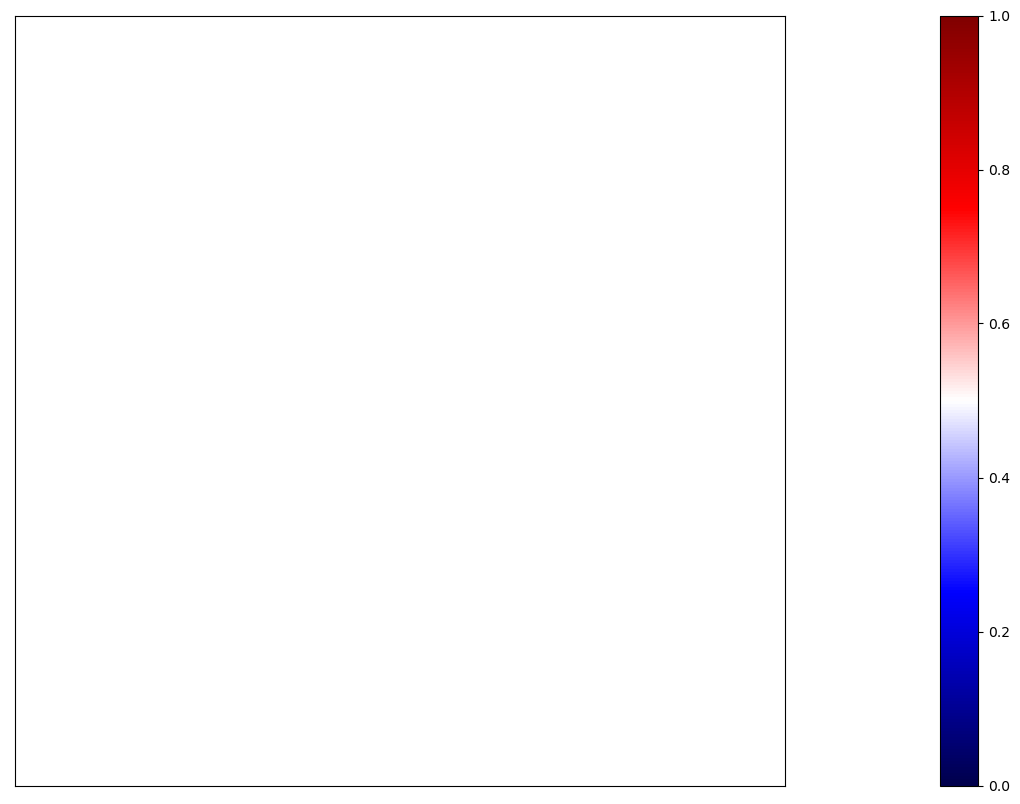

Heatmap has shape (0, 0)


/tmp/ipykernel_12475/3572449379.py:10: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(array, cmap="seismic")
/tmp/ipykernel_12475/3572449379.py:10: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(array, cmap="seismic")


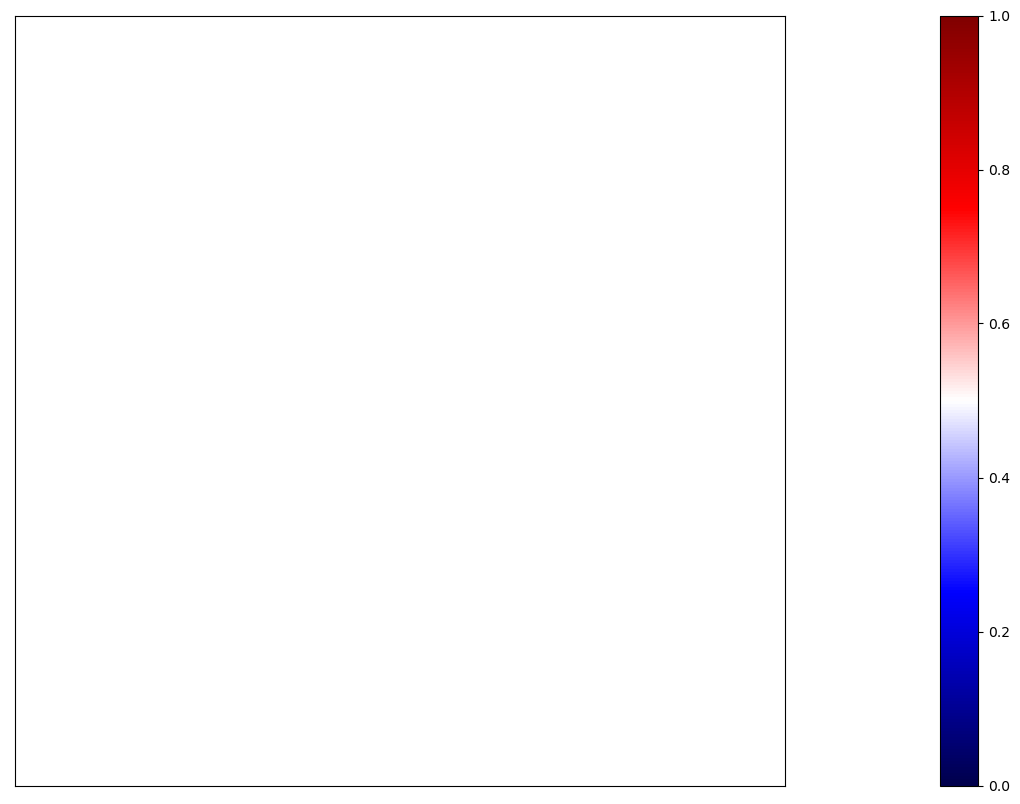

Heatmap has shape (0, 0)


/tmp/ipykernel_12475/3572449379.py:10: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(array, cmap="seismic")
/tmp/ipykernel_12475/3572449379.py:10: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(array, cmap="seismic")


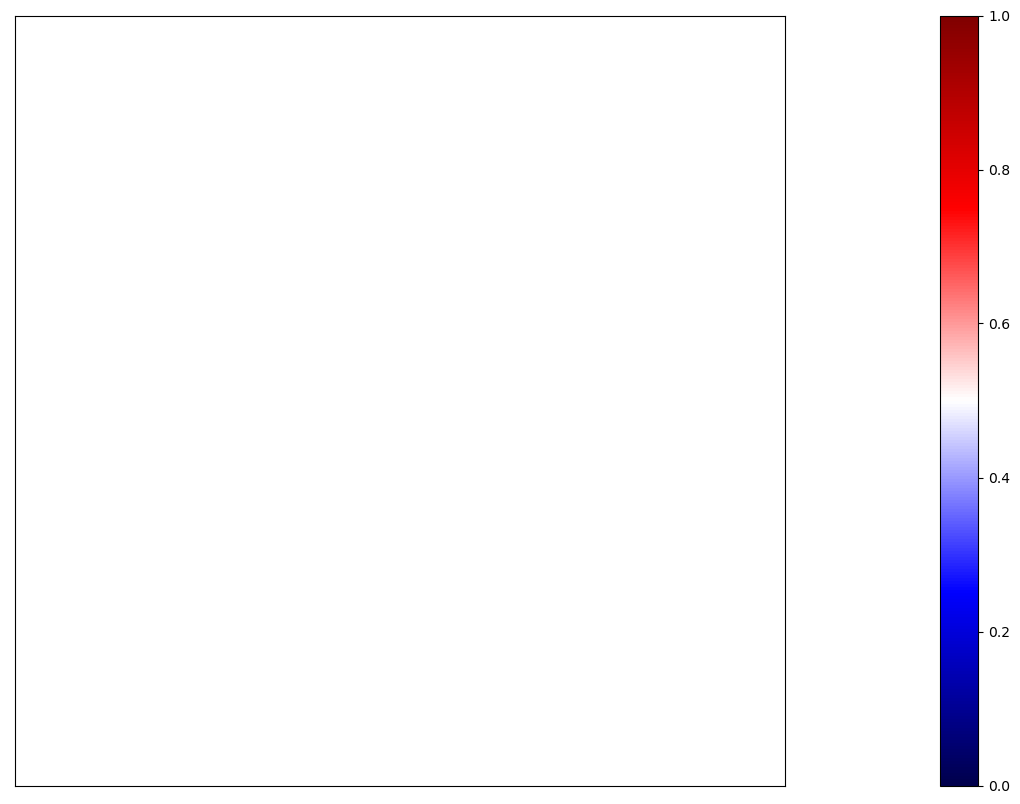

In [9]:
year_tick_freq = [29, 29, 29, 29, 29]
station_tick_freq = [12, 7, 7, 7, 7]

for i in range(len(metric_names)):
    plot_heatmap(metric_names[i], year_tick_freq[i], station_tick_freq[i])